## Imports

In [22]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import numpy as np
import pandas as pd
import pymongo
from pprint import pprint
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
import pickle
from operator import itemgetter

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score

import copy

## Load NYT Books Data

In [2]:
with open('merged_books_descriptions_pandas_df_2018-03-08.pkl', 'rb') as f:
    df = pickle.load(f)
df.shape

(11977, 20)

In [3]:
# remove common terms
pat = r'new york times|nyt|nytimes|bestselling|best selling|best-selling|bestseller|best seller|best-seller|author|originally|published|vol|printing|best|book'
df['description_primary'] = df['description_primary'].str.replace(pat, '', case=False)

In [4]:
# check how many nulls there are for primary description field
df['description_primary'].isnull().sum()

650

In [5]:
# filter them out in both original dataframe and primary descriptions array
df = df[df['description_primary'].notnull()]
df_desc = df['description_primary'].values
print('book descriptions to vectorize:',len(df_desc))

book descriptions to vectorize: 11327


In [6]:
print(df.shape)
print(len(df_desc))

(11327, 20)
11327


In [7]:
# take a look at an arbitrary description
df_desc[149]

'A DEEPER LOVE INSIDE Natural-born hustler Porsche Santiaga refuses to accept her new life in juvenile detention after her family is torn apart and fights to regain what she has lost.'

## Preprocessing - Count Vectorizer

In [9]:
lemmer = WordNetLemmatizer()
df_desc = [' '.join([lemmer.lemmatize(word) for word in text.split(' ')]) for text in df_desc]

In [74]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', token_pattern='\\b[a-z][a-z]+\\b', 
                                   strip_accents='unicode', min_df=5, max_df=.07)
count_vectorizer.fit(df_desc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.07, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='unicode', token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [75]:
# how many words were ignored using both max_df and min_df
print('total terms ignored:',len(count_vectorizer.stop_words_))

total terms ignored: 21767


- 14 words were ignored due to max_df=0.055 {'time', 'book', 'woman', 'life', 'family', 'series', 'love', 'vol', 'novel', 'man', 'story', 'world', 'years', 'new'}

In [76]:
# Create the term-document matrix
# Transpose it so the terms are the rows
counts = count_vectorizer.transform(df_desc).transpose()

In [77]:
counts.shape

(9086, 11327)

In [78]:
counts

<9086x11327 sparse matrix of type '<class 'numpy.int64'>'
	with 256789 stored elements in Compressed Sparse Column format>

In [79]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(counts)

In [80]:
corpus

In [81]:
# Map matrix of row ids to terms (tokens)
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
len(id2word)

9086

In [82]:
for i in range(10):
    print(id2word[i])

aang
aaron
abandon
abandoned
abbey
abby
abc
abducted
abduction
abigail


## LDA

In [83]:
# Create lda model
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=50)

2018-03-09 10:53:21,402 : INFO : using symmetric alpha at 0.3333333333333333
2018-03-09 10:53:21,404 : INFO : using symmetric eta at 0.3333333333333333
2018-03-09 10:53:21,407 : INFO : using serial LDA version on this node
2018-03-09 10:53:21,417 : INFO : running online (multi-pass) LDA training, 3 topics, 50 passes over the supplied corpus of 11327 documents, updating model once every 2000 documents, evaluating perplexity every 11327 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-09 10:53:21,436 : INFO : PROGRESS: pass 0, at document #2000/11327
2018-03-09 10:53:24,168 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:53:24,179 : INFO : topic #0 (0.333): 0.005*"wa" + 0.004*"american" + 0.003*"war" + 0.003*"make" + 0.003*"way" + 0.003*"history" + 0.003*"people" + 0.003*"day" + 0.002*"work" + 0.002*"come"
2018-03-09 10:53:24,180 : INFO : topic #1 (0.333): 0.004*"wa" + 0.003*"america" + 0.003*"batman" + 0.003*"day" + 0.0

2018-03-09 10:53:42,360 : INFO : topic diff=0.276863, rho=0.361232
2018-03-09 10:53:42,380 : INFO : PROGRESS: pass 1, at document #8000/11327
2018-03-09 10:53:44,072 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:53:44,077 : INFO : topic #0 (0.333): 0.006*"wa" + 0.004*"war" + 0.004*"american" + 0.003*"history" + 0.003*"america" + 0.003*"way" + 0.003*"star" + 0.003*"people" + 0.003*"president" + 0.002*"secret"
2018-03-09 10:53:44,078 : INFO : topic #1 (0.333): 0.003*"mother" + 0.003*"business" + 0.003*"work" + 0.003*"death" + 0.003*"help" + 0.003*"young" + 0.003*"murder" + 0.003*"old" + 0.003*"novel" + 0.003*"wa"
2018-03-09 10:53:44,079 : INFO : topic #2 (0.333): 0.007*"food" + 0.005*"recipe" + 0.005*"girl" + 0.004*"diet" + 0.004*"make" + 0.004*"home" + 0.004*"cook" + 0.004*"day" + 0.004*"novel" + 0.004*"help"
2018-03-09 10:53:44,080 : INFO : topic diff=0.274384, rho=0.361232
2018-03-09 10:53:44,103 : INFO : PROGRESS: pass 1, at document #1000

2018-03-09 10:54:00,937 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:54:00,942 : INFO : topic #0 (0.333): 0.006*"wa" + 0.005*"war" + 0.005*"american" + 0.004*"america" + 0.004*"history" + 0.003*"president" + 0.003*"way" + 0.002*"like" + 0.002*"political" + 0.002*"star"
2018-03-09 10:54:00,943 : INFO : topic #1 (0.333): 0.004*"mother" + 0.004*"murder" + 0.004*"work" + 0.003*"business" + 0.003*"death" + 0.003*"secret" + 0.003*"help" + 0.003*"young" + 0.003*"case" + 0.003*"novel"
2018-03-09 10:54:00,945 : INFO : topic #2 (0.333): 0.007*"food" + 0.006*"diet" + 0.006*"weight" + 0.005*"recipe" + 0.005*"day" + 0.005*"health" + 0.005*"body" + 0.005*"make" + 0.004*"vampire" + 0.004*"help"
2018-03-09 10:54:00,946 : INFO : topic diff=0.225896, rho=0.321686
2018-03-09 10:54:00,966 : INFO : PROGRESS: pass 3, at document #4000/11327
2018-03-09 10:54:02,449 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:54:02,45

2018-03-09 10:54:14,967 : INFO : topic #1 (0.333): 0.004*"murder" + 0.004*"mother" + 0.004*"death" + 0.004*"novel" + 0.004*"help" + 0.004*"secret" + 0.003*"business" + 0.003*"past" + 0.003*"young" + 0.003*"work"
2018-03-09 10:54:14,969 : INFO : topic #2 (0.333): 0.008*"food" + 0.006*"recipe" + 0.006*"make" + 0.005*"diet" + 0.005*"day" + 0.005*"health" + 0.005*"cook" + 0.004*"vampire" + 0.004*"body" + 0.004*"help"
2018-03-09 10:54:14,970 : INFO : topic diff=0.199545, rho=0.306232
2018-03-09 10:54:14,992 : INFO : PROGRESS: pass 4, at document #10000/11327
2018-03-09 10:54:16,348 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:54:16,352 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"war" + 0.005*"american" + 0.004*"america" + 0.004*"history" + 0.003*"president" + 0.003*"star" + 0.003*"way" + 0.002*"political" + 0.002*"power"
2018-03-09 10:54:16,353 : INFO : topic #1 (0.333): 0.004*"secret" + 0.004*"murder" + 0.004*"novel" + 0.004*"mother" + 0.004

2018-03-09 10:54:28,937 : INFO : topic #2 (0.333): 0.008*"food" + 0.006*"diet" + 0.006*"weight" + 0.006*"make" + 0.006*"recipe" + 0.006*"day" + 0.006*"health" + 0.005*"body" + 0.005*"vampire" + 0.004*"plan"
2018-03-09 10:54:28,937 : INFO : topic diff=0.179629, rho=0.281011
2018-03-09 10:54:28,957 : INFO : PROGRESS: pass 6, at document #4000/11327
2018-03-09 10:54:30,196 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:54:30,200 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"war" + 0.005*"american" + 0.005*"america" + 0.004*"history" + 0.003*"president" + 0.003*"way" + 0.002*"star" + 0.002*"great" + 0.002*"like"
2018-03-09 10:54:30,202 : INFO : topic #1 (0.333): 0.004*"novel" + 0.004*"murder" + 0.004*"death" + 0.004*"mother" + 0.004*"secret" + 0.004*"girl" + 0.004*"help" + 0.003*"home" + 0.003*"old" + 0.003*"past"
2018-03-09 10:54:30,203 : INFO : topic #2 (0.333): 0.009*"food" + 0.006*"make" + 0.006*"recipe" + 0.006*"diet" + 0.005*"vampire" + 0.

2018-03-09 10:54:41,141 : INFO : PROGRESS: pass 7, at document #10000/11327
2018-03-09 10:54:42,325 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:54:42,329 : INFO : topic #0 (0.333): 0.006*"war" + 0.006*"wa" + 0.005*"american" + 0.004*"america" + 0.004*"history" + 0.003*"president" + 0.003*"star" + 0.003*"way" + 0.003*"power" + 0.002*"political"
2018-03-09 10:54:42,331 : INFO : topic #1 (0.333): 0.005*"novel" + 0.005*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"mother" + 0.004*"old" + 0.004*"young" + 0.004*"death" + 0.003*"help" + 0.003*"past"
2018-03-09 10:54:42,332 : INFO : topic #2 (0.333): 0.009*"food" + 0.008*"diet" + 0.006*"make" + 0.006*"recipe" + 0.006*"health" + 0.006*"day" + 0.005*"guide" + 0.005*"weight" + 0.005*"plan" + 0.005*"cook"
2018-03-09 10:54:42,333 : INFO : topic diff=0.190778, rho=0.270532
2018-03-09 10:54:43,780 : INFO : -8.388 per-word bound, 335.1 perplexity estimate based on a held-out corpus of 1327 documents w

2018-03-09 10:54:54,891 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"war" + 0.005*"american" + 0.005*"america" + 0.004*"history" + 0.003*"president" + 0.003*"people" + 0.003*"work" + 0.003*"way" + 0.003*"star"
2018-03-09 10:54:54,892 : INFO : topic #1 (0.333): 0.005*"novel" + 0.004*"secret" + 0.004*"murder" + 0.004*"death" + 0.004*"mother" + 0.004*"girl" + 0.004*"old" + 0.004*"dark" + 0.004*"home" + 0.004*"young"
2018-03-09 10:54:54,894 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.006*"recipe" + 0.005*"diet" + 0.005*"guide" + 0.005*"vampire" + 0.005*"day" + 0.005*"health" + 0.005*"help" + 0.005*"weight"
2018-03-09 10:54:54,895 : INFO : topic diff=0.155779, rho=0.252671
2018-03-09 10:54:54,915 : INFO : PROGRESS: pass 9, at document #6000/11327
2018-03-09 10:54:56,042 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:54:56,047 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"war" + 0.005*"american" + 0.004*"america" + 0.004*"history"

2018-03-09 10:55:06,226 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"diet" + 0.007*"make" + 0.006*"recipe" + 0.006*"guide" + 0.005*"health" + 0.005*"day" + 0.005*"weight" + 0.005*"help" + 0.005*"way"
2018-03-09 10:55:06,227 : INFO : topic diff=0.169256, rho=0.244972
2018-03-09 10:55:07,584 : INFO : -8.349 per-word bound, 326.1 perplexity estimate based on a held-out corpus of 1327 documents with 35441 words
2018-03-09 10:55:07,585 : INFO : PROGRESS: pass 10, at document #11327/11327
2018-03-09 10:55:08,295 : INFO : merging changes from 1327 documents into a model of 11327 documents
2018-03-09 10:55:08,300 : INFO : topic #0 (0.333): 0.006*"war" + 0.006*"wa" + 0.005*"american" + 0.004*"america" + 0.004*"history" + 0.003*"work" + 0.003*"president" + 0.003*"power" + 0.003*"people" + 0.003*"way"
2018-03-09 10:55:08,301 : INFO : topic #1 (0.333): 0.006*"novel" + 0.005*"secret" + 0.005*"girl" + 0.005*"mother" + 0.004*"old" + 0.004*"murder" + 0.004*"young" + 0.004*"death" + 0.004*"friend" 

2018-03-09 10:55:18,151 : INFO : topic diff=0.138367, rho=0.231475
2018-03-09 10:55:18,172 : INFO : PROGRESS: pass 12, at document #6000/11327
2018-03-09 10:55:19,274 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:55:19,278 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"war" + 0.005*"american" + 0.004*"america" + 0.004*"history" + 0.003*"president" + 0.003*"people" + 0.003*"work" + 0.003*"way" + 0.003*"personal"
2018-03-09 10:55:19,279 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"girl" + 0.004*"murder" + 0.004*"mother" + 0.004*"secret" + 0.004*"death" + 0.004*"old" + 0.004*"friend" + 0.004*"past" + 0.004*"young"
2018-03-09 10:55:19,280 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.006*"recipe" + 0.005*"guide" + 0.005*"help" + 0.005*"diet" + 0.005*"way" + 0.005*"day" + 0.005*"vampire" + 0.004*"health"
2018-03-09 10:55:19,281 : INFO : topic diff=0.136001, rho=0.231475
2018-03-09 10:55:19,303 : INFO : PROGRESS: pass 12, at docu

2018-03-09 10:55:30,411 : INFO : PROGRESS: pass 13, at document #11327/11327
2018-03-09 10:55:31,116 : INFO : merging changes from 1327 documents into a model of 11327 documents
2018-03-09 10:55:31,120 : INFO : topic #0 (0.333): 0.006*"war" + 0.006*"wa" + 0.005*"american" + 0.004*"america" + 0.004*"history" + 0.003*"work" + 0.003*"president" + 0.003*"people" + 0.003*"power" + 0.003*"way"
2018-03-09 10:55:31,121 : INFO : topic #1 (0.333): 0.006*"novel" + 0.005*"secret" + 0.005*"girl" + 0.004*"mother" + 0.004*"murder" + 0.004*"old" + 0.004*"young" + 0.004*"friend" + 0.004*"death" + 0.003*"home"
2018-03-09 10:55:31,123 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"diet" + 0.007*"make" + 0.006*"guide" + 0.005*"recipe" + 0.005*"help" + 0.005*"health" + 0.005*"weight" + 0.005*"day" + 0.005*"way"
2018-03-09 10:55:31,124 : INFO : topic diff=0.151700, rho=0.225512
2018-03-09 10:55:31,146 : INFO : PROGRESS: pass 14, at document #2000/11327
2018-03-09 10:55:32,181 : INFO : merging changes from

2018-03-09 10:55:41,925 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"girl" + 0.004*"murder" + 0.004*"secret" + 0.004*"mother" + 0.004*"death" + 0.004*"friend" + 0.004*"old" + 0.004*"dark" + 0.004*"young"
2018-03-09 10:55:41,926 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.006*"recipe" + 0.005*"guide" + 0.005*"help" + 0.005*"diet" + 0.005*"way" + 0.005*"day" + 0.004*"health" + 0.004*"vampire"
2018-03-09 10:55:41,927 : INFO : topic diff=0.122341, rho=0.214850
2018-03-09 10:55:41,948 : INFO : PROGRESS: pass 15, at document #8000/11327
2018-03-09 10:55:42,990 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:55:42,994 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"war" + 0.006*"american" + 0.004*"america" + 0.004*"history" + 0.003*"people" + 0.003*"work" + 0.003*"president" + 0.003*"star" + 0.003*"personal"
2018-03-09 10:55:42,996 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"fr

2018-03-09 10:55:53,588 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"diet" + 0.007*"make" + 0.006*"guide" + 0.005*"help" + 0.005*"recipe" + 0.005*"health" + 0.005*"weight" + 0.005*"way" + 0.005*"day"
2018-03-09 10:55:53,589 : INFO : topic diff=0.138389, rho=0.210057
2018-03-09 10:55:53,609 : INFO : PROGRESS: pass 17, at document #2000/11327
2018-03-09 10:55:54,642 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:55:54,646 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"war" + 0.006*"american" + 0.005*"america" + 0.004*"history" + 0.003*"president" + 0.003*"work" + 0.003*"people" + 0.003*"way" + 0.003*"power"
2018-03-09 10:55:54,647 : INFO : topic #1 (0.333): 0.006*"novel" + 0.005*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"mother" + 0.004*"friend" + 0.004*"old" + 0.004*"young" + 0.004*"death" + 0.003*"past"
2018-03-09 10:55:54,648 : INFO : topic #2 (0.333): 0.007*"food" + 0.007*"make" + 0.006*"diet" + 0.005*"guide" + 0.005*"recipe" + 0

2018-03-09 10:56:04,206 : INFO : topic diff=0.112818, rho=0.201360
2018-03-09 10:56:04,227 : INFO : PROGRESS: pass 18, at document #8000/11327
2018-03-09 10:56:05,249 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:56:05,254 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.006*"war" + 0.005*"america" + 0.004*"history" + 0.003*"people" + 0.003*"work" + 0.003*"president" + 0.003*"star" + 0.003*"personal"
2018-03-09 10:56:05,255 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"friend" + 0.004*"death" + 0.004*"old" + 0.004*"mother" + 0.004*"young" + 0.004*"past"
2018-03-09 10:56:05,257 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.006*"recipe" + 0.005*"guide" + 0.005*"diet" + 0.005*"help" + 0.005*"day" + 0.005*"way" + 0.005*"health" + 0.004*"cook"
2018-03-09 10:56:05,258 : INFO : topic diff=0.113129, rho=0.201360
2018-03-09 10:56:05,280 : INFO : PROGRESS: pass 18, at docume

2018-03-09 10:56:15,736 : INFO : PROGRESS: pass 20, at document #2000/11327
2018-03-09 10:56:16,738 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:56:16,743 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.004*"history" + 0.003*"president" + 0.003*"work" + 0.003*"people" + 0.003*"way" + 0.003*"memoir"
2018-03-09 10:56:16,744 : INFO : topic #1 (0.333): 0.006*"novel" + 0.005*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"friend" + 0.004*"old" + 0.004*"mother" + 0.004*"young" + 0.004*"death" + 0.003*"wa"
2018-03-09 10:56:16,745 : INFO : topic #2 (0.333): 0.007*"food" + 0.007*"make" + 0.006*"diet" + 0.005*"guide" + 0.005*"recipe" + 0.005*"help" + 0.005*"weight" + 0.005*"way" + 0.005*"health" + 0.005*"day"
2018-03-09 10:56:16,746 : INFO : topic diff=0.110856, rho=0.193661
2018-03-09 10:56:16,768 : INFO : PROGRESS: pass 20, at document #4000/11327
2018-03-09 10:56:17,817 : INFO : merging changes from 2

2018-03-09 10:56:27,355 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"friend" + 0.004*"death" + 0.004*"old" + 0.004*"young" + 0.004*"past" + 0.004*"mother"
2018-03-09 10:56:27,357 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.006*"recipe" + 0.005*"guide" + 0.005*"help" + 0.005*"diet" + 0.005*"way" + 0.005*"day" + 0.005*"health" + 0.004*"cook"
2018-03-09 10:56:27,358 : INFO : topic diff=0.105702, rho=0.190128
2018-03-09 10:56:27,380 : INFO : PROGRESS: pass 21, at document #10000/11327
2018-03-09 10:56:28,437 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:56:28,442 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.006*"war" + 0.004*"america" + 0.004*"history" + 0.003*"president" + 0.003*"work" + 0.003*"people" + 0.003*"personal" + 0.003*"way"
2018-03-09 10:56:28,443 : INFO : topic #1 (0.333): 0.007*"novel" + 0.005*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"frien

2018-03-09 10:56:38,957 : INFO : topic #2 (0.333): 0.007*"food" + 0.007*"make" + 0.006*"diet" + 0.005*"guide" + 0.005*"recipe" + 0.005*"help" + 0.005*"way" + 0.005*"weight" + 0.005*"health" + 0.005*"day"
2018-03-09 10:56:38,957 : INFO : topic diff=0.104261, rho=0.183607
2018-03-09 10:56:38,979 : INFO : PROGRESS: pass 23, at document #4000/11327
2018-03-09 10:56:40,027 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:56:40,032 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.004*"history" + 0.003*"president" + 0.003*"people" + 0.003*"work" + 0.003*"personal" + 0.003*"great"
2018-03-09 10:56:40,033 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"death" + 0.004*"friend" + 0.004*"dark" + 0.004*"old" + 0.004*"young" + 0.003*"home"
2018-03-09 10:56:40,035 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.005*"diet" + 0.005*"guide" + 0.005*"recipe" 

2018-03-09 10:56:49,517 : INFO : topic diff=0.099626, rho=0.180588
2018-03-09 10:56:49,539 : INFO : PROGRESS: pass 24, at document #10000/11327
2018-03-09 10:56:50,591 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:56:50,596 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.004*"history" + 0.003*"president" + 0.003*"work" + 0.003*"people" + 0.003*"personal" + 0.003*"way"
2018-03-09 10:56:50,597 : INFO : topic #1 (0.333): 0.007*"novel" + 0.005*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"friend" + 0.004*"old" + 0.004*"young" + 0.004*"death" + 0.003*"wa" + 0.003*"mother"
2018-03-09 10:56:50,598 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"diet" + 0.007*"make" + 0.006*"guide" + 0.006*"recipe" + 0.005*"help" + 0.005*"health" + 0.005*"way" + 0.005*"day" + 0.005*"weight"
2018-03-09 10:56:50,599 : INFO : topic diff=0.114959, rho=0.180588
2018-03-09 10:56:51,896 : INFO : -8.294 per-word bound, 313.8

2018-03-09 10:57:00,998 : INFO : PROGRESS: pass 26, at document #4000/11327
2018-03-09 10:57:02,046 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:57:02,051 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.004*"history" + 0.003*"president" + 0.003*"people" + 0.003*"work" + 0.003*"personal" + 0.003*"great"
2018-03-09 10:57:02,052 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"death" + 0.004*"friend" + 0.004*"dark" + 0.004*"old" + 0.004*"young" + 0.003*"wa"
2018-03-09 10:57:02,053 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.005*"diet" + 0.005*"guide" + 0.005*"recipe" + 0.005*"way" + 0.005*"help" + 0.005*"health" + 0.005*"day" + 0.005*"weight"
2018-03-09 10:57:02,054 : INFO : topic diff=0.097354, rho=0.174972
2018-03-09 10:57:02,076 : INFO : PROGRESS: pass 26, at document #6000/11327
2018-03-09 10:57:03,127 : INFO : merging changes from

2018-03-09 10:57:12,568 : INFO : topic #1 (0.333): 0.007*"novel" + 0.005*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"friend" + 0.004*"old" + 0.004*"young" + 0.004*"death" + 0.003*"wa" + 0.003*"home"
2018-03-09 10:57:12,569 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.007*"diet" + 0.006*"guide" + 0.006*"recipe" + 0.005*"help" + 0.005*"way" + 0.005*"health" + 0.005*"day" + 0.005*"weight"
2018-03-09 10:57:12,570 : INFO : topic diff=0.109126, rho=0.172354
2018-03-09 10:57:13,872 : INFO : -8.290 per-word bound, 313.0 perplexity estimate based on a held-out corpus of 1327 documents with 35441 words
2018-03-09 10:57:13,873 : INFO : PROGRESS: pass 27, at document #11327/11327
2018-03-09 10:57:14,552 : INFO : merging changes from 1327 documents into a model of 11327 documents
2018-03-09 10:57:14,556 : INFO : topic #0 (0.333): 0.006*"wa" + 0.005*"american" + 0.005*"war" + 0.005*"america" + 0.004*"history" + 0.003*"president" + 0.003*"work" + 0.003*"people" + 0.003*"personal" 

2018-03-09 10:57:23,957 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.005*"diet" + 0.005*"way" + 0.005*"guide" + 0.005*"recipe" + 0.005*"help" + 0.005*"health" + 0.005*"day" + 0.005*"weight"
2018-03-09 10:57:23,958 : INFO : topic diff=0.092600, rho=0.167451
2018-03-09 10:57:23,980 : INFO : PROGRESS: pass 29, at document #6000/11327
2018-03-09 10:57:25,008 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:57:25,013 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.004*"history" + 0.003*"president" + 0.003*"people" + 0.003*"work" + 0.003*"personal" + 0.003*"memoir"
2018-03-09 10:57:25,014 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"girl" + 0.004*"secret" + 0.004*"murder" + 0.004*"friend" + 0.004*"death" + 0.004*"old" + 0.004*"young" + 0.004*"dark" + 0.003*"past"
2018-03-09 10:57:25,015 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.006*"recipe" + 0.005*"way" + 0.005*"guide" 

2018-03-09 10:57:34,384 : INFO : topic diff=0.104045, rho=0.165152
2018-03-09 10:57:35,691 : INFO : -8.287 per-word bound, 312.4 perplexity estimate based on a held-out corpus of 1327 documents with 35441 words
2018-03-09 10:57:35,692 : INFO : PROGRESS: pass 30, at document #11327/11327
2018-03-09 10:57:36,360 : INFO : merging changes from 1327 documents into a model of 11327 documents
2018-03-09 10:57:36,365 : INFO : topic #0 (0.333): 0.006*"wa" + 0.005*"american" + 0.005*"war" + 0.005*"america" + 0.005*"history" + 0.003*"president" + 0.003*"work" + 0.003*"people" + 0.003*"personal" + 0.003*"memoir"
2018-03-09 10:57:36,366 : INFO : topic #1 (0.333): 0.006*"novel" + 0.005*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"old" + 0.004*"friend" + 0.004*"young" + 0.004*"death" + 0.003*"mother" + 0.003*"home"
2018-03-09 10:57:36,368 : INFO : topic #2 (0.333): 0.007*"food" + 0.007*"make" + 0.006*"diet" + 0.005*"guide" + 0.005*"help" + 0.005*"way" + 0.005*"recipe" + 0.005*"health" + 0.005*"w

2018-03-09 10:57:45,787 : INFO : PROGRESS: pass 32, at document #6000/11327
2018-03-09 10:57:46,837 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:57:46,842 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.004*"history" + 0.003*"president" + 0.003*"people" + 0.003*"work" + 0.003*"memoir" + 0.003*"personal"
2018-03-09 10:57:46,843 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"girl" + 0.004*"secret" + 0.004*"murder" + 0.004*"friend" + 0.004*"death" + 0.004*"old" + 0.004*"young" + 0.004*"dark" + 0.003*"past"
2018-03-09 10:57:46,844 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.006*"recipe" + 0.005*"way" + 0.005*"guide" + 0.005*"help" + 0.005*"diet" + 0.005*"business" + 0.005*"health" + 0.004*"day"
2018-03-09 10:57:46,845 : INFO : topic diff=0.087622, rho=0.160823
2018-03-09 10:57:46,867 : INFO : PROGRESS: pass 32, at document #8000/11327
2018-03-09 10:57:47,891 : INFO : merging changes

2018-03-09 10:57:58,222 : INFO : merging changes from 1327 documents into a model of 11327 documents
2018-03-09 10:57:58,226 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.005*"history" + 0.003*"president" + 0.003*"work" + 0.003*"people" + 0.003*"memoir" + 0.003*"personal"
2018-03-09 10:57:58,227 : INFO : topic #1 (0.333): 0.006*"novel" + 0.005*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"old" + 0.004*"friend" + 0.004*"young" + 0.004*"death" + 0.003*"mother" + 0.003*"home"
2018-03-09 10:57:58,229 : INFO : topic #2 (0.333): 0.007*"food" + 0.007*"make" + 0.006*"diet" + 0.005*"way" + 0.005*"help" + 0.005*"guide" + 0.005*"recipe" + 0.005*"health" + 0.005*"weight" + 0.005*"day"
2018-03-09 10:57:58,230 : INFO : topic diff=0.101672, rho=0.158783
2018-03-09 10:57:58,251 : INFO : PROGRESS: pass 34, at document #2000/11327
2018-03-09 10:57:59,252 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:57:59,258

2018-03-09 10:58:08,862 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"girl" + 0.004*"secret" + 0.004*"murder" + 0.004*"friend" + 0.004*"death" + 0.004*"old" + 0.004*"young" + 0.004*"dark" + 0.003*"past"
2018-03-09 10:58:08,863 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.005*"recipe" + 0.005*"way" + 0.005*"help" + 0.005*"guide" + 0.005*"diet" + 0.005*"business" + 0.005*"health" + 0.004*"day"
2018-03-09 10:58:08,864 : INFO : topic diff=0.084132, rho=0.154925
2018-03-09 10:58:08,884 : INFO : PROGRESS: pass 35, at document #8000/11327
2018-03-09 10:58:09,889 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:58:09,893 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.004*"history" + 0.003*"president" + 0.003*"people" + 0.003*"work" + 0.003*"star" + 0.003*"memoir"
2018-03-09 10:58:09,894 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"frien

2018-03-09 10:58:20,230 : INFO : topic #2 (0.333): 0.007*"food" + 0.007*"make" + 0.006*"diet" + 0.005*"way" + 0.005*"help" + 0.005*"guide" + 0.005*"recipe" + 0.005*"health" + 0.005*"weight" + 0.005*"day"
2018-03-09 10:58:20,231 : INFO : topic diff=0.097904, rho=0.153099
2018-03-09 10:58:20,251 : INFO : PROGRESS: pass 37, at document #2000/11327
2018-03-09 10:58:21,337 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:58:21,347 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.005*"history" + 0.003*"president" + 0.003*"work" + 0.003*"people" + 0.003*"memoir" + 0.003*"political"
2018-03-09 10:58:21,350 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"friend" + 0.004*"old" + 0.004*"young" + 0.004*"death" + 0.003*"wa" + 0.003*"mother"
2018-03-09 10:58:21,352 : INFO : topic #2 (0.333): 0.007*"food" + 0.007*"make" + 0.006*"diet" + 0.005*"way" + 0.005*"help" + 

2018-03-09 10:58:31,894 : INFO : topic diff=0.080998, rho=0.149632
2018-03-09 10:58:31,915 : INFO : PROGRESS: pass 38, at document #8000/11327
2018-03-09 10:58:33,150 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:58:33,156 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.004*"history" + 0.003*"president" + 0.003*"people" + 0.003*"work" + 0.003*"star" + 0.003*"memoir"
2018-03-09 10:58:33,159 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"friend" + 0.004*"old" + 0.004*"death" + 0.004*"young" + 0.003*"past" + 0.003*"wa"
2018-03-09 10:58:33,162 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.005*"recipe" + 0.005*"way" + 0.005*"help" + 0.005*"guide" + 0.005*"diet" + 0.005*"business" + 0.005*"day" + 0.005*"health"
2018-03-09 10:58:33,163 : INFO : topic diff=0.081096, rho=0.149632
2018-03-09 10:58:33,193 : INFO : PROGRESS: pass 38, at document

2018-03-09 10:58:46,545 : INFO : PROGRESS: pass 40, at document #2000/11327
2018-03-09 10:58:47,629 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:58:47,635 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.005*"history" + 0.004*"president" + 0.003*"work" + 0.003*"people" + 0.003*"memoir" + 0.003*"political"
2018-03-09 10:58:47,637 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"friend" + 0.004*"old" + 0.004*"young" + 0.004*"death" + 0.003*"wa" + 0.003*"mother"
2018-03-09 10:58:47,638 : INFO : topic #2 (0.333): 0.007*"food" + 0.007*"make" + 0.006*"diet" + 0.005*"way" + 0.005*"help" + 0.005*"guide" + 0.005*"recipe" + 0.005*"health" + 0.005*"weight" + 0.005*"day"
2018-03-09 10:58:47,640 : INFO : topic diff=0.081481, rho=0.146390
2018-03-09 10:58:47,665 : INFO : PROGRESS: pass 40, at document #4000/11327
2018-03-09 10:58:48,836 : INFO : merging changes 

2018-03-09 10:58:58,929 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"friend" + 0.004*"old" + 0.004*"death" + 0.004*"young" + 0.003*"past" + 0.003*"wa"
2018-03-09 10:58:58,930 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.005*"recipe" + 0.005*"way" + 0.005*"help" + 0.005*"guide" + 0.005*"diet" + 0.005*"business" + 0.005*"health" + 0.005*"day"
2018-03-09 10:58:58,932 : INFO : topic diff=0.078325, rho=0.144846
2018-03-09 10:58:58,957 : INFO : PROGRESS: pass 41, at document #10000/11327
2018-03-09 10:59:00,083 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:59:00,088 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.005*"history" + 0.003*"president" + 0.003*"work" + 0.003*"people" + 0.003*"personal" + 0.003*"great"
2018-03-09 10:59:00,089 : INFO : topic #1 (0.333): 0.007*"novel" + 0.005*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"fri

2018-03-09 10:59:10,804 : INFO : topic #2 (0.333): 0.007*"food" + 0.007*"make" + 0.006*"diet" + 0.005*"way" + 0.005*"help" + 0.005*"guide" + 0.005*"recipe" + 0.005*"health" + 0.005*"weight" + 0.005*"business"
2018-03-09 10:59:10,806 : INFO : topic diff=0.078792, rho=0.141900
2018-03-09 10:59:10,832 : INFO : PROGRESS: pass 43, at document #4000/11327
2018-03-09 10:59:12,054 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:59:12,058 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.005*"history" + 0.003*"president" + 0.003*"people" + 0.003*"work" + 0.003*"god" + 0.003*"memoir"
2018-03-09 10:59:12,059 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"friend" + 0.004*"death" + 0.004*"old" + 0.004*"dark" + 0.004*"young" + 0.003*"wa"
2018-03-09 10:59:12,060 : INFO : topic #2 (0.333): 0.007*"food" + 0.007*"make" + 0.005*"way" + 0.005*"diet" + 0.005*"help" + 0.0

2018-03-09 10:59:22,232 : INFO : topic diff=0.075840, rho=0.140492
2018-03-09 10:59:22,255 : INFO : PROGRESS: pass 44, at document #10000/11327
2018-03-09 10:59:23,305 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:59:23,309 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.005*"history" + 0.003*"president" + 0.003*"work" + 0.003*"people" + 0.003*"personal" + 0.003*"great"
2018-03-09 10:59:23,310 : INFO : topic #1 (0.333): 0.007*"novel" + 0.005*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"friend" + 0.004*"old" + 0.004*"young" + 0.004*"death" + 0.003*"wa" + 0.003*"home"
2018-03-09 10:59:23,311 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.006*"diet" + 0.005*"guide" + 0.005*"recipe" + 0.005*"way" + 0.005*"help" + 0.005*"health" + 0.005*"day" + 0.005*"business"
2018-03-09 10:59:23,312 : INFO : topic diff=0.087380, rho=0.140492
2018-03-09 10:59:24,838 : INFO : -8.277 per-word bound, 310

2018-03-09 10:59:34,319 : INFO : PROGRESS: pass 46, at document #4000/11327
2018-03-09 10:59:35,414 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 10:59:35,419 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.005*"history" + 0.003*"president" + 0.003*"people" + 0.003*"work" + 0.003*"god" + 0.003*"memoir"
2018-03-09 10:59:35,421 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"friend" + 0.004*"death" + 0.004*"old" + 0.004*"dark" + 0.004*"young" + 0.003*"wa"
2018-03-09 10:59:35,422 : INFO : topic #2 (0.333): 0.007*"food" + 0.007*"make" + 0.005*"way" + 0.005*"diet" + 0.005*"help" + 0.005*"guide" + 0.005*"recipe" + 0.005*"business" + 0.005*"health" + 0.005*"day"
2018-03-09 10:59:35,423 : INFO : topic diff=0.075070, rho=0.137799
2018-03-09 10:59:35,446 : INFO : PROGRESS: pass 46, at document #6000/11327
2018-03-09 10:59:36,554 : INFO : merging changes from 2

2018-03-09 10:59:46,790 : INFO : topic #1 (0.333): 0.007*"novel" + 0.005*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"friend" + 0.004*"old" + 0.004*"young" + 0.004*"death" + 0.003*"wa" + 0.003*"home"
2018-03-09 10:59:46,791 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.006*"diet" + 0.005*"way" + 0.005*"guide" + 0.005*"recipe" + 0.005*"help" + 0.005*"health" + 0.005*"business" + 0.005*"day"
2018-03-09 10:59:46,793 : INFO : topic diff=0.084768, rho=0.136509
2018-03-09 10:59:48,187 : INFO : -8.276 per-word bound, 309.9 perplexity estimate based on a held-out corpus of 1327 documents with 35441 words
2018-03-09 10:59:48,188 : INFO : PROGRESS: pass 47, at document #11327/11327
2018-03-09 10:59:48,911 : INFO : merging changes from 1327 documents into a model of 11327 documents
2018-03-09 10:59:48,915 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.005*"history" + 0.004*"president" + 0.003*"work" + 0.003*"memoir" + 0.003*"people" 

2018-03-09 10:59:59,145 : INFO : topic #2 (0.333): 0.007*"food" + 0.007*"make" + 0.005*"way" + 0.005*"help" + 0.005*"diet" + 0.005*"guide" + 0.005*"recipe" + 0.005*"business" + 0.005*"health" + 0.005*"day"
2018-03-09 10:59:59,146 : INFO : topic diff=0.072948, rho=0.134034
2018-03-09 10:59:59,168 : INFO : PROGRESS: pass 49, at document #6000/11327
2018-03-09 11:00:00,275 : INFO : merging changes from 2000 documents into a model of 11327 documents
2018-03-09 11:00:00,280 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.005*"history" + 0.003*"president" + 0.003*"people" + 0.003*"work" + 0.003*"memoir" + 0.003*"god"
2018-03-09 11:00:00,281 : INFO : topic #1 (0.333): 0.006*"novel" + 0.004*"girl" + 0.004*"secret" + 0.004*"murder" + 0.004*"friend" + 0.004*"old" + 0.004*"death" + 0.004*"young" + 0.003*"dark" + 0.003*"past"
2018-03-09 11:00:00,282 : INFO : topic #2 (0.333): 0.008*"food" + 0.007*"make" + 0.005*"way" + 0.005*"recipe" + 0.005*"help" + 0.

In [84]:
# 5 most important words for each topic
lda.print_topics(num_words=15, num_topics=-1)

2018-03-09 11:01:22,399 : INFO : topic #0 (0.333): 0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.005*"history" + 0.004*"president" + 0.003*"work" + 0.003*"memoir" + 0.003*"people" + 0.003*"god" + 0.003*"personal" + 0.003*"great" + 0.003*"star" + 0.003*"political" + 0.003*"power"
2018-03-09 11:01:22,400 : INFO : topic #1 (0.333): 0.006*"novel" + 0.005*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"old" + 0.004*"friend" + 0.004*"young" + 0.003*"death" + 0.003*"mother" + 0.003*"home" + 0.003*"wa" + 0.003*"past" + 0.003*"help" + 0.003*"dark" + 0.003*"daughter"
2018-03-09 11:01:22,402 : INFO : topic #2 (0.333): 0.007*"food" + 0.007*"make" + 0.006*"diet" + 0.005*"way" + 0.005*"help" + 0.005*"guide" + 0.005*"recipe" + 0.005*"health" + 0.005*"business" + 0.005*"day" + 0.005*"weight" + 0.004*"body" + 0.004*"like" + 0.004*"plan" + 0.004*"good"


[(0,
  '0.006*"wa" + 0.006*"american" + 0.005*"war" + 0.005*"america" + 0.005*"history" + 0.004*"president" + 0.003*"work" + 0.003*"memoir" + 0.003*"people" + 0.003*"god" + 0.003*"personal" + 0.003*"great" + 0.003*"star" + 0.003*"political" + 0.003*"power"'),
 (1,
  '0.006*"novel" + 0.005*"secret" + 0.004*"girl" + 0.004*"murder" + 0.004*"old" + 0.004*"friend" + 0.004*"young" + 0.003*"death" + 0.003*"mother" + 0.003*"home" + 0.003*"wa" + 0.003*"past" + 0.003*"help" + 0.003*"dark" + 0.003*"daughter"'),
 (2,
  '0.007*"food" + 0.007*"make" + 0.006*"diet" + 0.005*"way" + 0.005*"help" + 0.005*"guide" + 0.005*"recipe" + 0.005*"health" + 0.005*"business" + 0.005*"day" + 0.005*"weight" + 0.004*"body" + 0.004*"like" + 0.004*"plan" + 0.004*"good"')]

In [85]:
# top 5 terms per topic
lda.top_topics(corpus, topn=15)

2018-03-09 11:01:28,456 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-03-09 11:01:28,480 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-03-09 11:01:28,508 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-03-09 11:01:28,533 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-03-09 11:01:28,565 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-03-09 11:01:28,597 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-03-09 11:01:28,630 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-03-09 11:01:28,654 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-03-09 11:01:28,694 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-03-09 11:01:28,724 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2018-03-09 11:01:28,764 : INFO : CorpusAccumulator accumulated stats from 11000 documents


[([(0.007242092, 'food'),
   (0.006560208, 'make'),
   (0.0059956172, 'diet'),
   (0.005468201, 'way'),
   (0.0053738323, 'help'),
   (0.0052237962, 'guide'),
   (0.005123852, 'recipe'),
   (0.0050448272, 'health'),
   (0.004780631, 'business'),
   (0.004655416, 'day'),
   (0.0046334555, 'weight'),
   (0.004056852, 'body'),
   (0.0039179176, 'like'),
   (0.0038583698, 'plan'),
   (0.0038252808, 'good')],
  -2.06408814181564),
 ([(0.0063762465, 'novel'),
   (0.0046856557, 'secret'),
   (0.004400728, 'girl'),
   (0.0039820787, 'murder'),
   (0.0038024304, 'old'),
   (0.0037903145, 'friend'),
   (0.0036270246, 'young'),
   (0.003469297, 'death'),
   (0.003322869, 'mother'),
   (0.003294596, 'home'),
   (0.0032904348, 'wa'),
   (0.0032322574, 'past'),
   (0.0030956701, 'help'),
   (0.003056621, 'dark'),
   (0.0030531993, 'daughter')],
  -2.449164053675973),
 ([(0.0062675327, 'wa'),
   (0.0057016616, 'american'),
   (0.0052704653, 'war'),
   (0.004812469, 'america'),
   (0.004656917, 'histo

In [86]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
lda_corpus

In [87]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [88]:
# Check out some of the document vectors in the topic space
lda_docs[:5]

[[(0, 0.25282285), (1, 0.18830675), (2, 0.55887043)],
 [(0, 0.94329095), (1, 0.02664002), (2, 0.03006908)],
 [(0, 0.36136314), (2, 0.635075)],
 [(0, 0.022296699), (1, 0.02188222), (2, 0.9558211)],
 [(0, 0.016712043), (1, 0.016619883), (2, 0.96666807)]]

In [89]:
# sort topic probabilities to enable book labeling
lda_docs_sorted = [sorted(doc, key=lambda tup: tup[1], reverse=True) for doc in lda_docs]
lda_docs_sorted[:10]

[[(2, 0.55887043), (0, 0.25282285), (1, 0.18830675)],
 [(0, 0.94329095), (2, 0.03006908), (1, 0.02664002)],
 [(2, 0.635075), (0, 0.36136314)],
 [(2, 0.9558211), (0, 0.022296699), (1, 0.02188222)],
 [(2, 0.96666807), (0, 0.016712043), (1, 0.016619883)],
 [(1, 0.808676), (2, 0.16278337), (0, 0.028540658)],
 [(1, 0.9552785), (2, 0.022957195), (0, 0.021764256)],
 [(2, 0.56359863), (0, 0.27434257), (1, 0.1620588)],
 [(0, 0.5012917), (1, 0.28429756), (2, 0.21441074)],
 [(2, 0.50544536), (1, 0.2574444), (0, 0.23711023)]]

[0.55887043, 0.94329095, 0.635075, 0.9558211, 0.96666807, 0.808676, 0.9552785, 0.56359863, 0.5012917, 0.50544536]


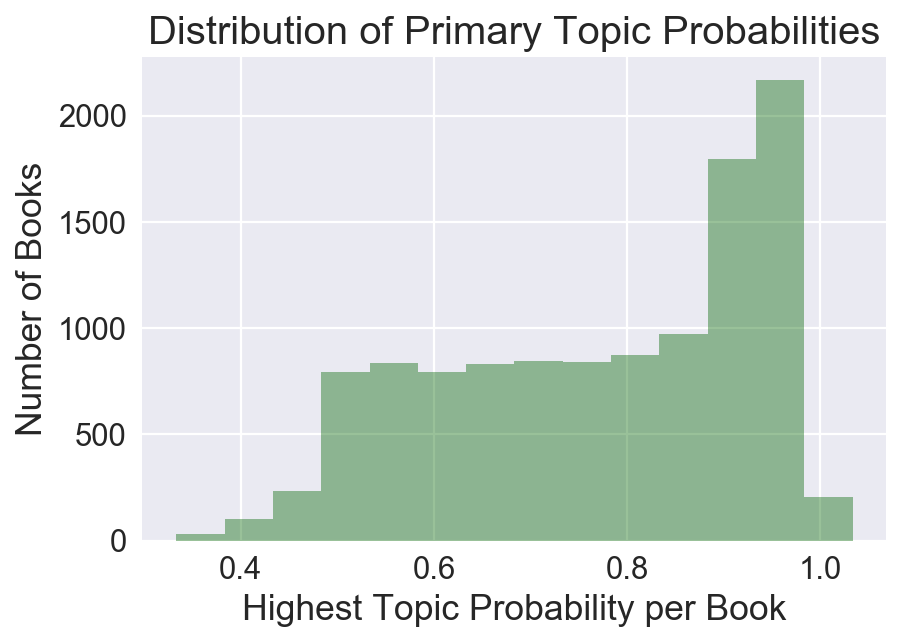

In [90]:
# visualize the distribution of highest topic probability per book
top_topic_probs = [doc[0][1] for doc in lda_docs_sorted]
print(top_topic_probs[:10])

binwidth = 0.05
histbins = np.arange(min(top_topic_probs), max(top_topic_probs) + binwidth, binwidth)

plt.figure(figsize=(6,4),dpi=160)
sns.distplot(top_topic_probs, color='darkgreen', kde=0, norm_hist=False, bins=histbins)
plt.xlabel('Highest Topic Probability per Book',size=16)
plt.ylabel('Number of Books',size=16)
plt.title('Distribution of Primary Topic Probabilities',size=18);

In [92]:
# assign highest prob topic as each book's label
lda_docs_labeled = [doc[0][0] for doc in lda_docs_sorted]
print('books assigned a topic:',len(lda_docs_labeled))
print(lda_docs_labeled[:10])

books assigned a topic: 11327
[2, 0, 2, 2, 2, 1, 1, 2, 0, 2]


In [93]:
df['lda_3topic'] = lda_docs_labeled
df.head(5)

,amazon_product_url,author,bestsellers_date,description_nyt,list_name,mongo_id_nyt,other_isbns,primary_isbn13,published_date,best_rank,...,authors,description_google,mongo_id_google,nyt_isbn13,title_google,merge_match,description_primary,nyt_desc_len,google_desc_len,lda_3topic
0,http://www.amazon.com/Give-You-My-Body-Scenes-...,Diana Gabaldon,2016-08-20,The author of the Outlander novels gives tips ...,Advice How-To and Miscellaneous,5a98e57d4f61b6bad451b147,"[{'isbn13': '9780399178573', 'isbn10': '039917...",9780399178573,2016-09-04,8,...,Diana Gabaldon,NEW YORK TIMES BESTSELLER • For writers lookin...,5a9a3e7b4f61b6d59c367047,9780399178573,"""I Give You My Body . . .""",both,"""I GIVE YOU MY BODY ..."" • For writers looki...",104.0,1115.0,2
1,http://www.amazon.com/Most-Blessed-Patriarchs-...,Annette Gordon-Reed and Peter S Onuf,2016-04-16,A character study that attempts to make sense ...,Hardcover Nonfiction,5a9755514f61b68dd7648074,"[{'isbn13': '9780871404428', 'isbn10': '087140...",9780871404428,2016-05-01,16,...,"Annette Gordon-Reed, Peter S. Onuf",A groundbreaking work of history that explicat...,5a97a2954f61b6966baa0905,9780871404428,Most Blessed of the Patriarchs,both,"""MOST BLESSED OF THE PATRIARCHS"" A groundbreak...",76.0,145.0,0
2,http://www.amazon.com/AskGaryVee-Entrepreneurs...,Gary Vaynerchuk,2016-03-12,The entrepreneur expands on subjects addressed...,Advice How-To and Miscellaneous,5a98e5654f61b6bad451afec,"[{'isbn13': '9780062273123', 'isbn10': '006227...",9780062273123,2016-03-27,6,...,Gary Vaynerchuk,The New York Times bestselling author draws fr...,5a9b4bb44f61b6ed19a8b951,9780062273123,#AskGaryVee,both,#ASKGARYVEE The draws from his popular show...,113.0,1428.0,2
3,http://www.amazon.com/GIRLBOSS-Sophia-Amoruso/...,Sophia Amoruso,2014-05-10,An online fashion retailer traces her path to ...,Advice How-To and Miscellaneous,5a98e5014f61b6bad451a8fe,"[{'isbn13': '9780399169274', 'isbn10': '039916...",9780399169274,2014-05-25,2,...,Sophia Amoruso,The founder of the Nasty Gal fashion e-tailer ...,5a9b4b714f61b6ed19a8b8b9,9780399169274,#Girlboss,both,#GIRLBOSS The founder of the Nasty Gal fashion...,54.0,275.0,2
4,http://www.amazon.com/The-100-Startup-Reinvent...,Chris Guillebeau,2012-05-26,How to turn ideas into income.,Hardcover Advice,5a98dfed4f61b6bad451824c,"[{'isbn13': '9780307951526', 'isbn10': '030795...",9780307951526,2012-06-10,6,...,Chris Guillebeau,Shares advice for transitioning away from unfu...,5a9a3dcf4f61b6d59c366fa8,9780307951526,The $100 Startup,both,$100 STARTUP Shares advice for transitioning a...,30.0,272.0,2


In [94]:
df['bestsellers_date'] = pd.to_datetime(df['bestsellers_date'], format='%Y-%m-%d')
df['published_date'] = pd.to_datetime(df['published_date'], format='%Y-%m-%d')
df.dtypes

amazon_product_url             object
author                         object
bestsellers_date       datetime64[ns]
description_nyt                object
list_name                      object
mongo_id_nyt                   object
other_isbns                    object
primary_isbn13                 object
published_date         datetime64[ns]
best_rank                       int64
title_nyt                      object
authors                        object
description_google             object
mongo_id_google                object
nyt_isbn13                     object
title_google                   object
merge_match                  category
description_primary            object
nyt_desc_len                  float64
google_desc_len               float64
lda_3topic                      int64
dtype: object

In [95]:
df.head()

,amazon_product_url,author,bestsellers_date,description_nyt,list_name,mongo_id_nyt,other_isbns,primary_isbn13,published_date,best_rank,...,authors,description_google,mongo_id_google,nyt_isbn13,title_google,merge_match,description_primary,nyt_desc_len,google_desc_len,lda_3topic
0,http://www.amazon.com/Give-You-My-Body-Scenes-...,Diana Gabaldon,2016-08-20,The author of the Outlander novels gives tips ...,Advice How-To and Miscellaneous,5a98e57d4f61b6bad451b147,"[{'isbn13': '9780399178573', 'isbn10': '039917...",9780399178573,2016-09-04,8,...,Diana Gabaldon,NEW YORK TIMES BESTSELLER • For writers lookin...,5a9a3e7b4f61b6d59c367047,9780399178573,"""I Give You My Body . . .""",both,"""I GIVE YOU MY BODY ..."" • For writers looki...",104.0,1115.0,2
1,http://www.amazon.com/Most-Blessed-Patriarchs-...,Annette Gordon-Reed and Peter S Onuf,2016-04-16,A character study that attempts to make sense ...,Hardcover Nonfiction,5a9755514f61b68dd7648074,"[{'isbn13': '9780871404428', 'isbn10': '087140...",9780871404428,2016-05-01,16,...,"Annette Gordon-Reed, Peter S. Onuf",A groundbreaking work of history that explicat...,5a97a2954f61b6966baa0905,9780871404428,Most Blessed of the Patriarchs,both,"""MOST BLESSED OF THE PATRIARCHS"" A groundbreak...",76.0,145.0,0
2,http://www.amazon.com/AskGaryVee-Entrepreneurs...,Gary Vaynerchuk,2016-03-12,The entrepreneur expands on subjects addressed...,Advice How-To and Miscellaneous,5a98e5654f61b6bad451afec,"[{'isbn13': '9780062273123', 'isbn10': '006227...",9780062273123,2016-03-27,6,...,Gary Vaynerchuk,The New York Times bestselling author draws fr...,5a9b4bb44f61b6ed19a8b951,9780062273123,#AskGaryVee,both,#ASKGARYVEE The draws from his popular show...,113.0,1428.0,2
3,http://www.amazon.com/GIRLBOSS-Sophia-Amoruso/...,Sophia Amoruso,2014-05-10,An online fashion retailer traces her path to ...,Advice How-To and Miscellaneous,5a98e5014f61b6bad451a8fe,"[{'isbn13': '9780399169274', 'isbn10': '039916...",9780399169274,2014-05-25,2,...,Sophia Amoruso,The founder of the Nasty Gal fashion e-tailer ...,5a9b4b714f61b6ed19a8b8b9,9780399169274,#Girlboss,both,#GIRLBOSS The founder of the Nasty Gal fashion...,54.0,275.0,2
4,http://www.amazon.com/The-100-Startup-Reinvent...,Chris Guillebeau,2012-05-26,How to turn ideas into income.,Hardcover Advice,5a98dfed4f61b6bad451824c,"[{'isbn13': '9780307951526', 'isbn10': '030795...",9780307951526,2012-06-10,6,...,Chris Guillebeau,Shares advice for transitioning away from unfu...,5a9a3dcf4f61b6d59c366fa8,9780307951526,The $100 Startup,both,$100 STARTUP Shares advice for transitioning a...,30.0,272.0,2


In [96]:
df['bestsellers_year'] = df['bestsellers_date'].dt.year

In [97]:
count_3topic_yearly = df.groupby(['lda_3topic','bestsellers_year'])['title_nyt'].count().unstack().transpose().reset_index()
count_3topic_yearly = count_3topic_yearly.rename(columns={0: 'war/history/memoir/politics', 
                                                          1: 'female/novel/drama/relationships', 
                                                          2: 'food/self-help/business/health'})
count_3topic_yearly

lda_3topic,bestsellers_year,war/history/memoir/politics,female/novel/drama/relationships,food/self-help/business/health
0,2008,242,392,129
1,2009,337,650,172
2,2010,325,581,174
3,2011,374,646,177
4,2012,415,669,186
5,2013,395,812,214
6,2014,415,702,187
7,2015,425,523,131
8,2016,429,671,137
9,2017,266,365,86


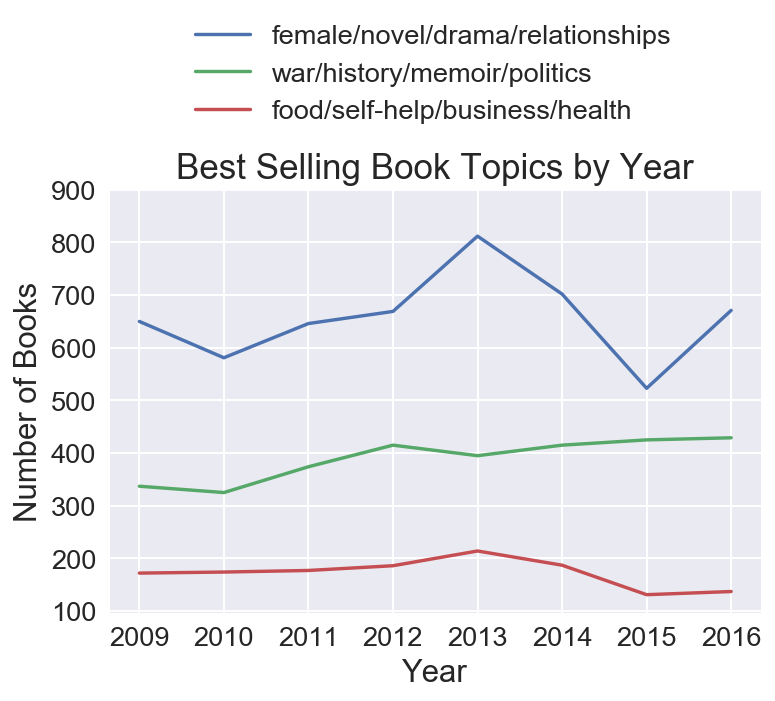

In [127]:
plt.figure(figsize=(6,4), dpi=140)
plt.plot(count_3topic_yearly['female/novel/drama/relationships'][1:9])
plt.plot(count_3topic_yearly['war/history/memoir/politics'][1:9])
plt.plot(count_3topic_yearly['food/self-help/business/health'][1:9])
plt.yticks(range(100,1000,100))
plt.xticks(range(1,9),count_3topic_yearly['bestsellers_year'][1:9])
plt.xlabel('Year',size=16)
plt.ylabel('Number of Books',size=16)
plt.title('Best Selling Book Topics by Year', size=18)
plt.legend(loc='upper right', bbox_to_anchor=(0.9, 1.45), fontsize='small');

In [ ]:
# percentage of books in corpus by topic


## LDA Perplexity scores

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 50]


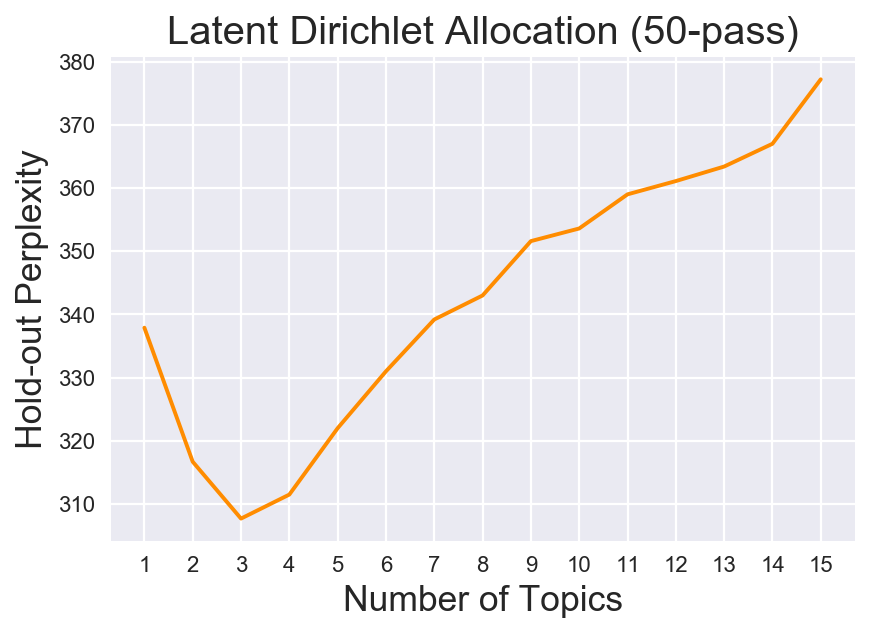

In [34]:
# LDA models with 50 passes and varying # of topics
# based on unigrams 
xlab = list(range(1,16)) + [20] + [50]
print(xlab)
perp_scores = [337.9,316.7,307.7,311.5,322.0,331.0,339.2,343.0,351.6,353.6,359.0,361.1,363.4,367.0,377.2,391.9,472.7]

plt.figure(figsize=(6,4), dpi=160)
plt.plot(perp_scores[:15], color='darkorange')
plt.xticks(list(range(len(xlab[:15]))),xlab[:15])
plt.xlabel('Number of Topics',size=16)
plt.ylabel('Hold-out Perplexity',size=16)
plt.title('Latent Dirichlet Allocation (50-pass)',size=18);

## Cluster in LDA 50-dimension space

In [32]:
# create new df from the topic vectors for each book, filling in zero values
index = list(range(9603))
columns = list(range(50))
df_book_topics = pd.DataFrame(index=index, columns=columns)
df_book_topics.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_book_topics.shape

(9603, 50)

In [34]:
df_book_topics.fillna(value=0, inplace=True)
df_book_topics.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
for idx, doc in enumerate(lda_docs):
    for topic in doc:
        df_book_topics.iloc[idx,topic[0]] = topic[1]
df_book_topics.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.127747,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.701562,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.105473,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.979583,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [60]:
# now with reduced dimensionality, cluster the books
SSEs = []
Sil_coefs = []
for k in range(40,60):
    print('{} clusters'.format(k))
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(df_book_topics)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(df_book_topics, labels, metric='euclidean'))
    SSEs.append(km.inertia_)
    
    #print(Sil_coefs)
    #print(labels)

40 clusters
41 clusters
42 clusters
43 clusters
44 clusters
45 clusters
46 clusters
47 clusters
48 clusters
49 clusters
50 clusters
51 clusters
52 clusters
53 clusters
54 clusters
55 clusters
56 clusters
57 clusters
58 clusters
59 clusters


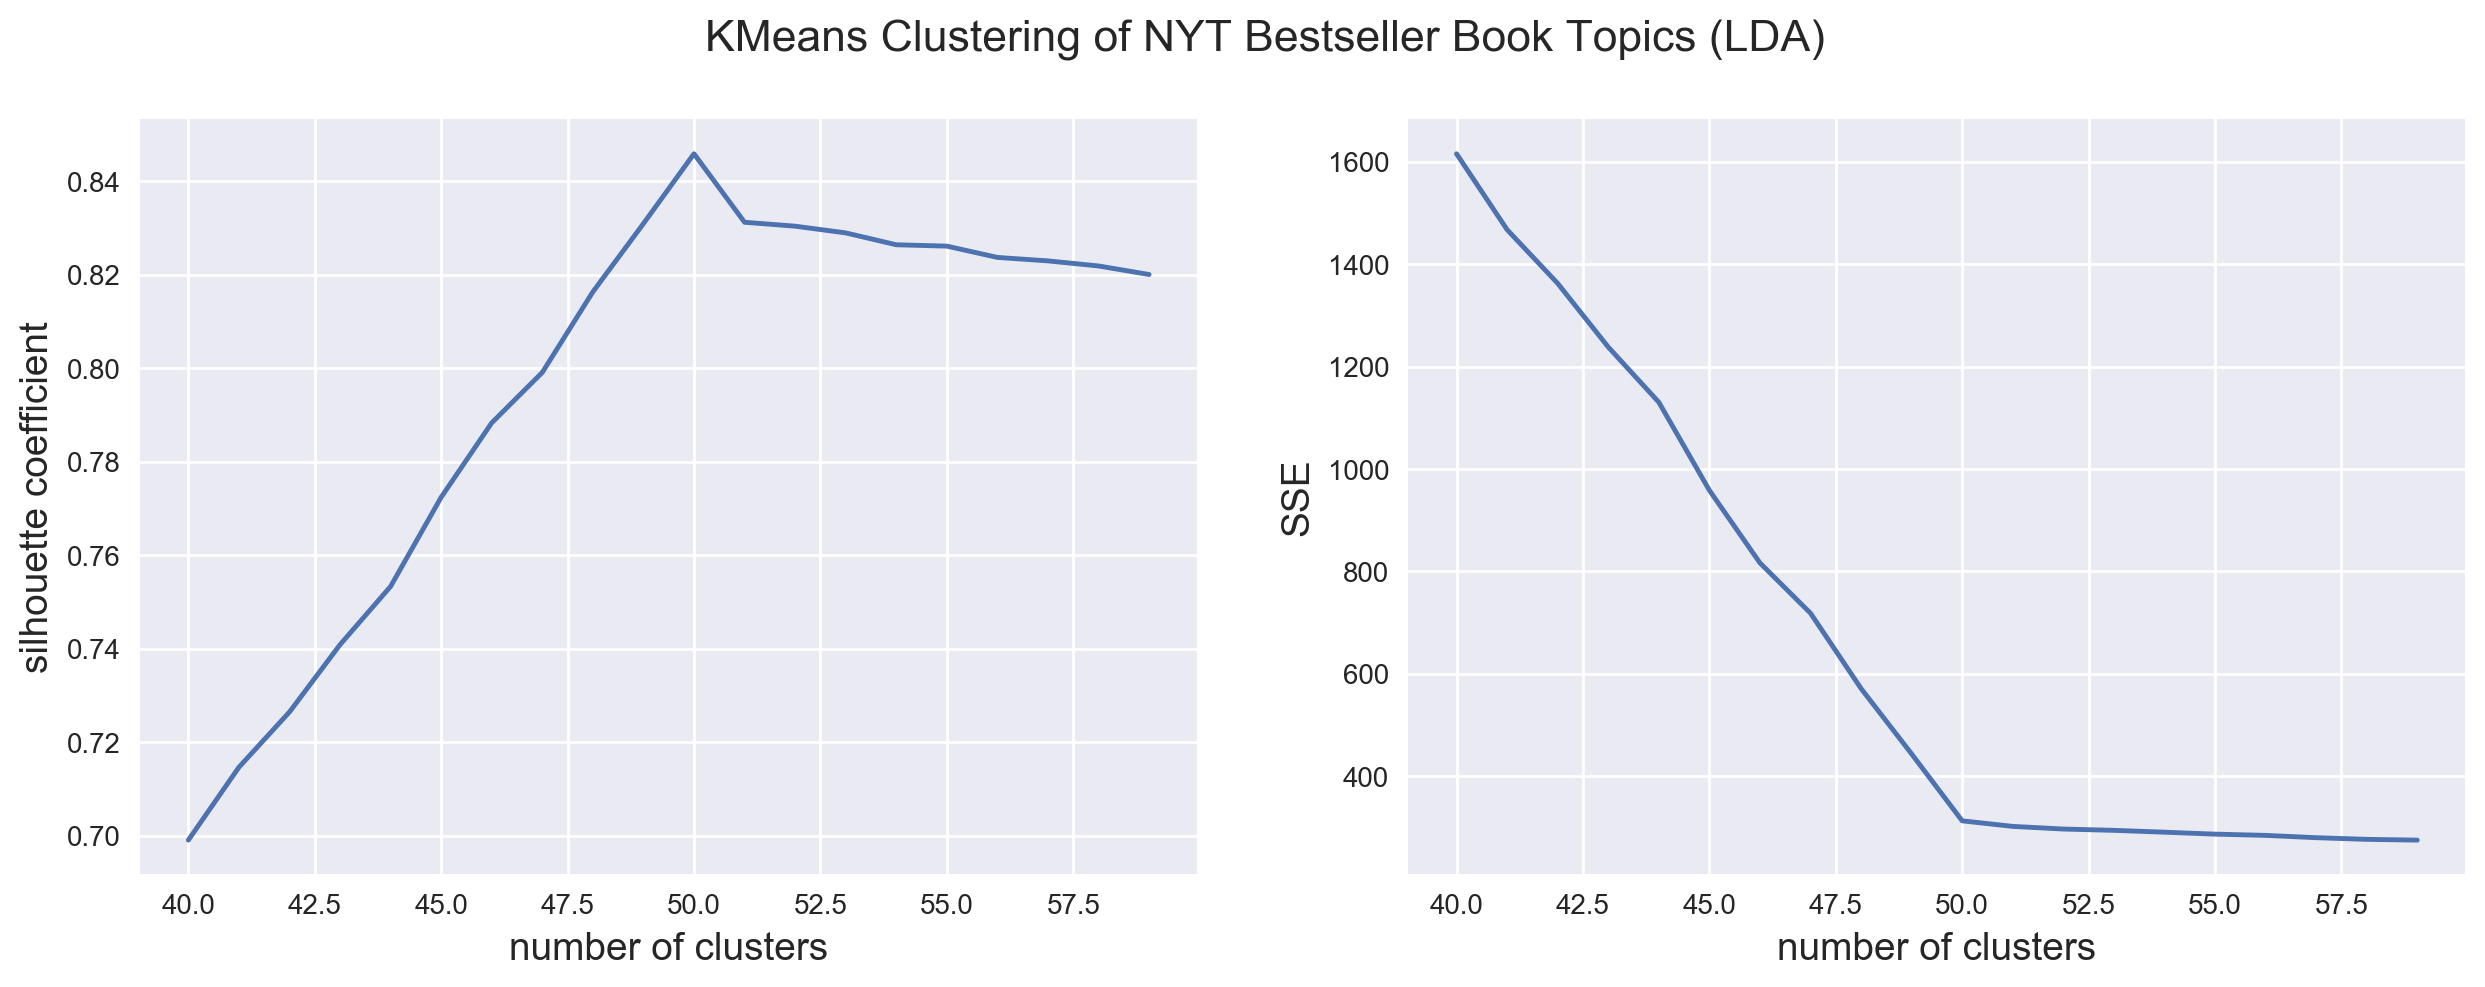

In [64]:
# plot silhouette coefficients and SSEs (elbow plot)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(40,60)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters', size=14)
ax1.set_ylabel('silhouette coefficient', size=14)

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters', size=14)
ax2.set_ylabel('SSE', size=14)

plt.suptitle('KMeans Clustering of NYT Bestseller Book Topics (LDA)', size=16);

In [68]:
# how do cluster labels for 50-cluster model line up with book metadata?
km = KMeans(n_clusters=50, random_state=37)
km.fit(df_book_topics)
labels = km.labels_

df['lda_50_km_50'] = labels
df.head()

,amazon_product_url,author,bestsellers_date,description_nyt,list_name,mongo_id_nyt,other_isbns,primary_isbn13,published_date,best_rank,...,authors,description_google,mongo_id_google,nyt_isbn13,title_google,merge_match,description_primary,nyt_desc_len,google_desc_len,lda_50_km_50
0,http://www.amazon.com/Give-You-My-Body-Scenes-...,Diana Gabaldon,2016-08-20,The author of the Outlander novels gives tips ...,Advice How-To and Miscellaneous,5a98e57d4f61b6bad451b147,"[{'isbn10': '0399178570', 'isbn13': '978039917...",9780399178573,2016-09-04,8,...,Diana Gabaldon,NEW YORK TIMES BESTSELLER • For writers lookin...,5a9a3e7b4f61b6d59c367047,9780399178573,"""I Give You My Body . . .""",both,• For writers looking to make sure their nex...,104.0,1115.0,43
1,http://www.amazon.com/Most-Blessed-Patriarchs-...,Annette Gordon-Reed and Peter S Onuf,2016-04-16,A character study that attempts to make sense ...,Hardcover Nonfiction,5a9755514f61b68dd7648074,"[{'isbn10': '0871404427', 'isbn13': '978087140...",9780871404428,2016-05-01,16,...,"Annette Gordon-Reed, Peter S. Onuf",A groundbreaking work of history that explicat...,5a97a2954f61b6966baa0905,9780871404428,Most Blessed of the Patriarchs,both,A groundbreaking work of history that explicat...,76.0,145.0,35
2,http://www.amazon.com/AskGaryVee-Entrepreneurs...,Gary Vaynerchuk,2016-03-12,The entrepreneur expands on subjects addressed...,Advice How-To and Miscellaneous,5a98e5654f61b6bad451afec,"[{'isbn10': '0062273124', 'isbn13': '978006227...",9780062273123,2016-03-27,6,...,Gary Vaynerchuk,The New York Times bestselling author draws fr...,5a9b4bb44f61b6ed19a8b951,9780062273123,#AskGaryVee,both,The draws from his popular show #AskGaryVee...,113.0,1428.0,8
3,http://www.amazon.com/GIRLBOSS-Sophia-Amoruso/...,Sophia Amoruso,2014-05-10,An online fashion retailer traces her path to ...,Advice How-To and Miscellaneous,5a98e5014f61b6bad451a8fe,"[{'isbn10': '039916927X', 'isbn13': '978039916...",9780399169274,2014-05-25,2,...,Sophia Amoruso,The founder of the Nasty Gal fashion e-tailer ...,5a9b4b714f61b6ed19a8b8b9,9780399169274,#Girlboss,both,The founder of the Nasty Gal fashion e-tailer ...,54.0,275.0,25
4,http://www.amazon.com/The-100-Startup-Reinvent...,Chris Guillebeau,2012-05-26,How to turn ideas into income.,Hardcover Advice,5a98dfed4f61b6bad451824c,"[{'isbn10': '0307951529', 'isbn13': '978030795...",9780307951526,2012-06-10,6,...,Chris Guillebeau,Shares advice for transitioning away from unfu...,5a9a3dcf4f61b6d59c366fa8,9780307951526,The $100 Startup,both,Shares advice for transitioning away from unfu...,30.0,272.0,9


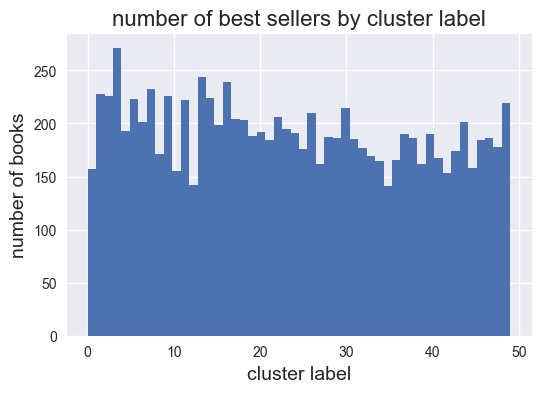

In [105]:
# number of books by cluster
plt.figure(figsize=(6,4), dpi=100)
plt.hist(df['lda_50_km_50'], bins=len(df['lda_50_km_50'].unique()))
plt.xlabel('cluster label',size=14)
plt.ylabel('number of books',size=14)
plt.title('number of best sellers by cluster label',size=16);

In [114]:
df.columns

Index(['amazon_product_url', 'author', 'bestsellers_date', 'description_nyt',
       'list_name', 'mongo_id_nyt', 'other_isbns', 'primary_isbn13',
       'published_date', 'best_rank', 'title_nyt', 'authors',
       'description_google', 'mongo_id_google', 'nyt_isbn13', 'title_google',
       'merge_match', 'description_primary', 'nyt_desc_len', 'google_desc_len',
       'lda_50_km_50'],
      dtype='object')

In [133]:
pd.get_option('display.max_colwidth')

50

In [136]:
pd.get_option('display.max_rows')

250

In [156]:
pd.reset_option('display.max_colwidth')

In [135]:
# inspect a few books per cluster to examine cluster relevance
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 250)

df.sort_values('lda_50_km_50').groupby('lda_50_km_50')['lda_50_km_50','list_name','title_nyt','description_primary'].head(5)
#pd.reset_option('display.max_colwidth')

,lda_50_km_50,list_name,title_nyt,description_primary
4456,0,Paperback Graphic Books,MARCH TRILOGY,All three volumes of Representative John Lewis's memoir of the civil rights movement are collected here.
7946,0,Trade Fiction Paperback,THE LITTLE PARIS BOOKSHOP,Monsieur Perdu dispenses books to help mend broken hearts and decides to finally confront his own long-ago heartbreak.
5181,0,Hardcover Fiction,ONE SUMMER,"As Christmas nears, a terminally ill man is preparing his family for his death when another tragedy strikes."
7910,0,Manga,"THE LEGEND OF ZELDA: LEGENDARY EDITION, VOL. 2","The adaptation of several story arcs from Nintendo’s Zelda video game series continues. In this volume, the Oracle of Seasons."
5244,0,Hardcover Nonfiction,OUR LADY OF GUADALUPE,"Traces the influence of the sixteenth-century apparition in Mexico City, chronicling her evolution as a cultural symbol and her significance in the Catholic church's future in the western world."
2246,1,Series Books,DORK DIARIES,Nikki Maxwell navigates the halls of middle school.
9379,1,Hardcover Nonfiction,TURN RIGHT AT MACHU PICCHU,"Traces the 's recreation of Hiram Bingham III's discovery of the ancient citadel, Machu Picchu, in the Andes Mountains of Peru, describing his struggles with rudimentary survival tools and his experiences at the sides of local guides."
4295,1,Hardcover Fiction,LORD OF MOUNTAINS,"Further adventures in a postapocalyptic America,"
1040,1,Young Adult Hardcover,BERNIE SANDERS GUIDE TO POLITICAL REVOLUTION,The Vermont senator and former presidential candidate continues the fight for his agenda for political and social change.
4964,1,Mass Market Paperback,NINE DRAGONS,The Los Angeles detective Harry Bosch fights crime at home and in Hong Kong.


## Preprocessing - TFIDF

In [8]:
lemmer = WordNetLemmatizer()
df_desc = [' '.join([lemmer.lemmatize(word) for word in text.split(' ')]) for text in df_desc]

In [38]:
# Vectorize the text using TFIDF
tfidf = TfidfVectorizer(ngram_range=(1,3), stop_words='english', token_pattern='\\b[a-z][a-z]+\\b', 
                        strip_accents='unicode', min_df=5, max_df=.07)
tfidf_vecs = tfidf.fit_transform(df_desc)

#df_tfidf = pd.DataFrame(tfidf_vecs.todense(), columns=tfidf.get_feature_names())
#df_tfidf.head()

print('n-grams created:',tfidf_vecs.shape[1])
print('n-grams ignored:',len(tfidf.stop_words_))

n-grams created: 12535
n-grams ignored: 607653


In [39]:
# Convert sparse matrix of counts to a gensim corpus and transpose
tfidf_corpus = matutils.Sparse2Corpus(tfidf_vecs.transpose())

# Row indices
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

# This is a hack for Python 3!
id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                         id2word=id2word)

2018-03-09 10:36:31,066 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-09 10:36:31,548 : INFO : adding document #10000 to Dictionary(0 unique tokens: [])
2018-03-09 10:36:31,728 : INFO : built Dictionary(12535 unique tokens: ['lasting weight loss', 'wa young', 'divulges', 'healer', 'beard award']...) from 11327 documents (total 47747 corpus positions)


## LSI

In [40]:
# "fit" lsi model on tfidf corpus and reduce dimensions
lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=30)

2018-03-09 10:36:34,459 : INFO : using serial LSI version on this node
2018-03-09 10:36:34,461 : INFO : updating model with new documents
2018-03-09 10:36:34,590 : INFO : preparing a new chunk of documents
2018-03-09 10:36:34,859 : INFO : using 100 extra samples and 2 power iterations
2018-03-09 10:36:34,860 : INFO : 1st phase: constructing (12535, 130) action matrix
2018-03-09 10:36:35,017 : INFO : orthonormalizing (12535, 130) action matrix
2018-03-09 10:36:35,437 : INFO : 2nd phase: running dense svd on (130, 11327) matrix
2018-03-09 10:36:35,564 : INFO : computing the final decomposition
2018-03-09 10:36:35,566 : INFO : keeping 30 factors (discarding 60.535% of energy spectrum)
2018-03-09 10:36:35,589 : INFO : processed documents up to #11327
2018-03-09 10:36:35,602 : INFO : topic #0(8.203): -0.134*"wa" + -0.111*"war" + -0.108*"girl" + -0.104*"novel" + -0.101*"secret" + -0.097*"way" + -0.095*"day" + -0.094*"young" + -0.092*"american" + -0.091*"help"
2018-03-09 10:36:35,604 : INFO :

In [41]:
# Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
lsi_corpus = lsi[tfidf_corpus]

# Dump the resulting document vectors into a list so we can take a look
lsi_docs = [doc for doc in lsi_corpus]
#lsi_docs[0]

## LSI Topics & Singular Values

In [71]:
pprint(lsi.show_topics(num_words=15))

[(0,
  '0.136*"wa" + 0.113*"novel" + 0.112*"war" + 0.111*"girl" + 0.108*"secret" + '
  '0.101*"day" + 0.098*"young" + 0.098*"way" + 0.094*"american" + 0.093*"help" '
  '+ 0.093*"make" + 0.092*"mother" + 0.090*"death" + 0.089*"home" + '
  '0.088*"work"'),
 (1,
  '-0.257*"diet" + -0.234*"food" + -0.203*"weight" + -0.180*"recipe" + '
  '0.159*"novel" + 0.149*"girl" + -0.148*"cook" + -0.135*"health" + '
  '0.127*"murder" + -0.125*"day" + 0.123*"vampire" + -0.119*"plan" + '
  '-0.116*"loss" + 0.111*"dark" + -0.098*"guide"'),
 (2,
  '-0.394*"girl" + 0.347*"war" + 0.217*"american" + 0.185*"president" + '
  '0.170*"america" + -0.166*"school" + -0.141*"diet" + -0.139*"vampire" + '
  '0.138*"history" + 0.120*"obama" + -0.115*"food" + 0.109*"political" + '
  '-0.106*"weight" + 0.102*"account" + -0.100*"recipe"'),
 (3,
  '-0.511*"batman" + 0.409*"girl" + -0.246*"dark" + -0.149*"vampire" + '
  '0.146*"memoir" + -0.133*"novel" + -0.130*"gotham" + -0.114*"city" + '
  '0.113*"mother" + 0.113*"school" 

In [72]:
# top 10 words per topic in order of significance (positive coef only)
for topic in lsi.show_topics(num_words=10, formatted=False):
    pos_terms = [term for term in topic[1] if term[1]>0]
    print('topic {}'.format(topic[0]))
    pprint(pos_terms)

topic 0
[('wa', 0.1355032935615532),
 ('novel', 0.1126728441139166),
 ('war', 0.11233544191776483),
 ('girl', 0.1106697187485045),
 ('secret', 0.10825247553473079),
 ('day', 0.10109828814557274),
 ('young', 0.09768640853052273),
 ('way', 0.09765651990519078),
 ('american', 0.09444608237591075),
 ('help', 0.09345409704946593)]
topic 1
[('novel', 0.15897943711771492),
 ('girl', 0.14878183280501842),
 ('murder', 0.12697249994799165)]
topic 2
[('war', 0.34688900303659337),
 ('american', 0.2167865697855285),
 ('president', 0.18453782081857964),
 ('america', 0.16980626389196227),
 ('history', 0.13795833341804387),
 ('obama', 0.11969485890955582)]
topic 3
[('girl', 0.4089896800604777),
 ('memoir', 0.146356355872599),
 ('mother', 0.11305356045030639),
 ('school', 0.11278512172187052)]
topic 4
[('murder', 0.26287210732607813),
 ('killer', 0.17184096131769075),
 ('detective', 0.16485015013160084),
 ('death', 0.14122643447600255),
 ('case', 0.1375018496953305)]
topic 5
[('vampire', 0.539546248780

In [42]:
# singular values (topics by significance)
sv = lsi.projection.s
sv

array([8.20258779, 5.2448029 , 4.93019561, 4.63907946, 4.58007443,
       4.46748122, 4.40290118, 4.32272206, 4.2469683 , 4.21649311,
       4.10579724, 4.08260515, 4.00549991, 3.97829334, 3.88857291,
       3.86203223, 3.79335787, 3.73566722, 3.72171952, 3.6654019 ,
       3.62446177, 3.60239641, 3.56812878, 3.54832159, 3.53017729,
       3.52483046, 3.50647553, 3.47123303, 3.44543931, 3.43486021])

In [74]:
plt.style.use('default')

In [48]:
plt.style.use('seaborn-darkgrid')

In [34]:
len(sv)

30

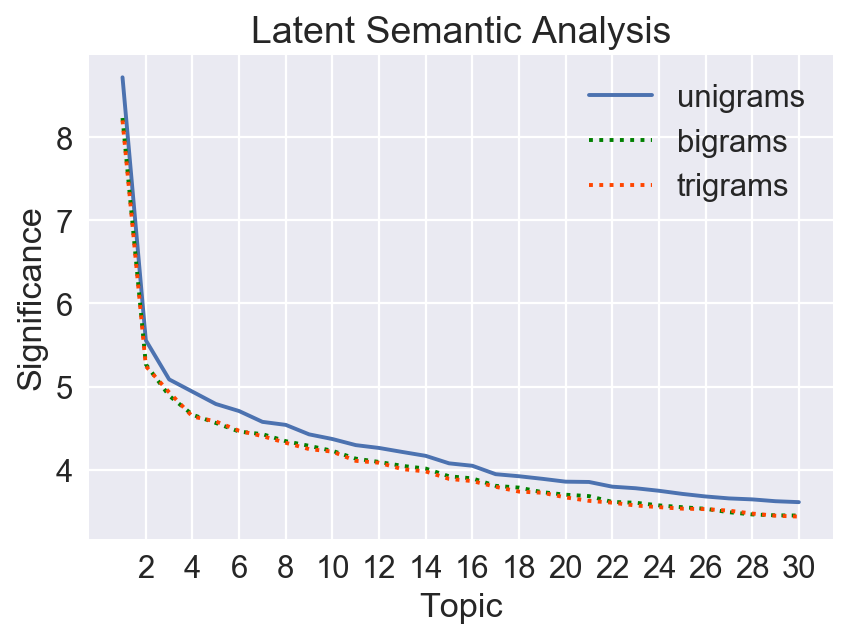

In [72]:
# elbow plot of topic significance
xloc = list(range(1,31,2))
xlab = list(range(2,32,2))
#print('x locs:',xloc)
#print('x labs:',xlab)

sns.set(font_scale=1.4)
plt.figure(figsize=(6,4), dpi=160)
plt.plot(sv_unigrams, linestyle='-', label='unigrams')
plt.plot(sv_bigrams, color='green', linestyle=':', label='bigrams')
plt.plot(sv, color='orangered', linestyle=':', label='trigrams')
plt.xticks(xloc,xlab)
plt.xlabel('Topic')
plt.ylabel('Significance')
plt.title('Latent Semantic Analysis')
plt.legend();

In [37]:
sv_unigrams = copy.deepcopy(sv)
#sv_bigrams = copy.deepcopy(sv)
#print(type(sv_bigrams))
print(sv_bigrams[:5])
print(sv_unigrams[:5])

[8.23075127 5.2670784  4.88964689 4.66075859 4.56167379]
[8.72081726 5.55676839 5.08572615 4.93800303 4.79000721]


## Truncated SVD

In [52]:
tsvd = TruncatedSVD(n_components=50, n_iter=10, random_state=37)
tsvd.fit(tfidf_vecs)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=10,
       random_state=37, tol=0.0)

In [53]:
tsvd.explained_variance_ratio_

array([0.00138477, 0.0027396 , 0.00230786, 0.00217298, 0.00205279,
       0.0019859 , 0.00188211, 0.00184998, 0.00176082, 0.0017122 ,
       0.00167804, 0.00164407, 0.00159867, 0.00157578, 0.00152071,
       0.00148951, 0.00143373, 0.00142645, 0.00142505, 0.00138614,
       0.00136327, 0.00134165, 0.00131715, 0.00130021, 0.00128286,
       0.0012586 , 0.00125031, 0.00124425, 0.00123819, 0.00122557,
       0.00121072, 0.00119864, 0.00119625, 0.00118731, 0.00116906,
       0.0011586 , 0.0011539 , 0.00114345, 0.00112532, 0.00111514,
       0.001108  , 0.00110471, 0.00109813, 0.00109054, 0.00107795,
       0.00107007, 0.00106091, 0.00105045, 0.00104875, 0.00103386])

In [54]:
tsvd.explained_variance_ratio_.sum()

0.0702509476088509

## Cosine Similarity

In [137]:
# create matrix of cosine similarities to compare books
index = similarities.MatrixSimilarity(lsi_docs, num_features=50)

2018-03-06 18:07:55,658 : INFO : creating matrix with 9603 documents and 50 features


In [176]:
# Return the sorted list of cosine similarities to the first document
sims = sorted(enumerate(index[lsi_docs[8346]]), key=lambda item: -item[1])

# get top 5 most similar books
most_sim_idx = [item[0] for item in sims[1:6]]
df.iloc[most_sim_idx,:]

,amazon_product_url,author,bestsellers_date,description_nyt,list_name,mongo_id_nyt,other_isbns,primary_isbn13,published_date,best_rank,...,authors,description_google,mongo_id_google,nyt_isbn13,title_google,merge_match,description_primary,nyt_desc_len,google_desc_len,lda_50_km_50
5715,http://www.amazon.com/Rescue-Me-Rachel-Gibson-...,Rachel Gibson,2012-06-02,"Everyone in Lovett, Tex., wants to see Sadie m...",Mass Market Paperback,5a9b467c4f61b6ed143511c7,"[{'isbn10': '0062069128', 'isbn13': '978006206...",9780062069122,2012-06-17,10,...,NaN,NaN,NaN,NaN,NaN,left_only,"Everyone in Lovett, Tex., wants to see Sadie m...",128.0,NaN,32
6381,http://www.amazon.com/Stake-Eggs-Cackleberry-C...,Laura Childs,2012-11-10,When the town’s most-hated banker dies in a sn...,Mass Market Paperback,5a9b46884f61b6ed14351396,"[{'isbn10': '0425255573', 'isbn13': '978042525...",9780425255575,2012-11-25,13,...,NaN,NaN,NaN,NaN,NaN,left_only,When the town’s most-hated banker dies in a sn...,149.0,NaN,31
5303,http://www.amazon.com/Parker-The-Score-Richard...,Darwyn Cooke,2012-07-28,"Parker, the antihero created by the novelist R...",Hardcover Graphic Books,5a9e19e64f61b625452723be,"[{'isbn10': '1613772084', 'isbn13': '978161377...",9781613772089,2012-08-12,7,...,NaN,NaN,NaN,NaN,NaN,left_only,"Parker, the antihero created by the novelist R...",135.0,NaN,13
4247,https://www.amazon.com/Little-Fires-Everywhere...,Celeste Ng,2018-01-13,An artist upends a quiet town outside Cleveland.,Combined Print and E-Book Fiction,5a95fd644f61b66319f1c51d,"[{'isbn10': '0735224293', 'isbn13': '978073522...",9780735224308,2018-01-28,4,...,NaN,NaN,NaN,NaN,NaN,left_only,An artist upends a quiet town outside Cleveland.,48.0,NaN,15
5002,http://www.amazon.com/No-Talking-Andrew-Clemen...,Andrew Clements,2009-06-27,A vow of silence among fifth graders becomes t...,Paperback Books,5a9e188f4f61b6254527172d,"[{'isbn10': '1416909842', 'isbn13': '978141690...",9781416909842,2009-07-12,9,...,NaN,NaN,NaN,NaN,NaN,left_only,A vow of silence among fifth graders becomes t...,66.0,NaN,6


In [ ]:
# IDEA: for each book, get the top 5 most similar books by LSI cosine similarity,
# then see how many of those 5 have the same topic number and/or cluster label from LDA (lda_50_km_50)

## Cluster in LSI 50-dimension space

In [47]:
# Convert the gensim-style corpus vecs to a numpy array for sklearn manipulations
books_lsi = matutils.corpus2dense(lsi_corpus, num_terms=50).transpose()
books_lsi.shape

(9603, 50)

In [112]:
# re-fit KMeans to compare with LDA space
SSEs = []
Sil_coefs = []
for k in range(40,60):
    print('{} clusters'.format(k))
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(books_lsi)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(books_lsi, labels, metric='euclidean'))
    SSEs.append(km.inertia_)
    
    #print(Sil_coefs)
    #print(labels)

40 clusters
41 clusters
42 clusters
43 clusters
44 clusters
45 clusters
46 clusters
47 clusters
48 clusters
49 clusters
50 clusters
51 clusters
52 clusters
53 clusters
54 clusters
55 clusters
56 clusters
57 clusters
58 clusters
59 clusters


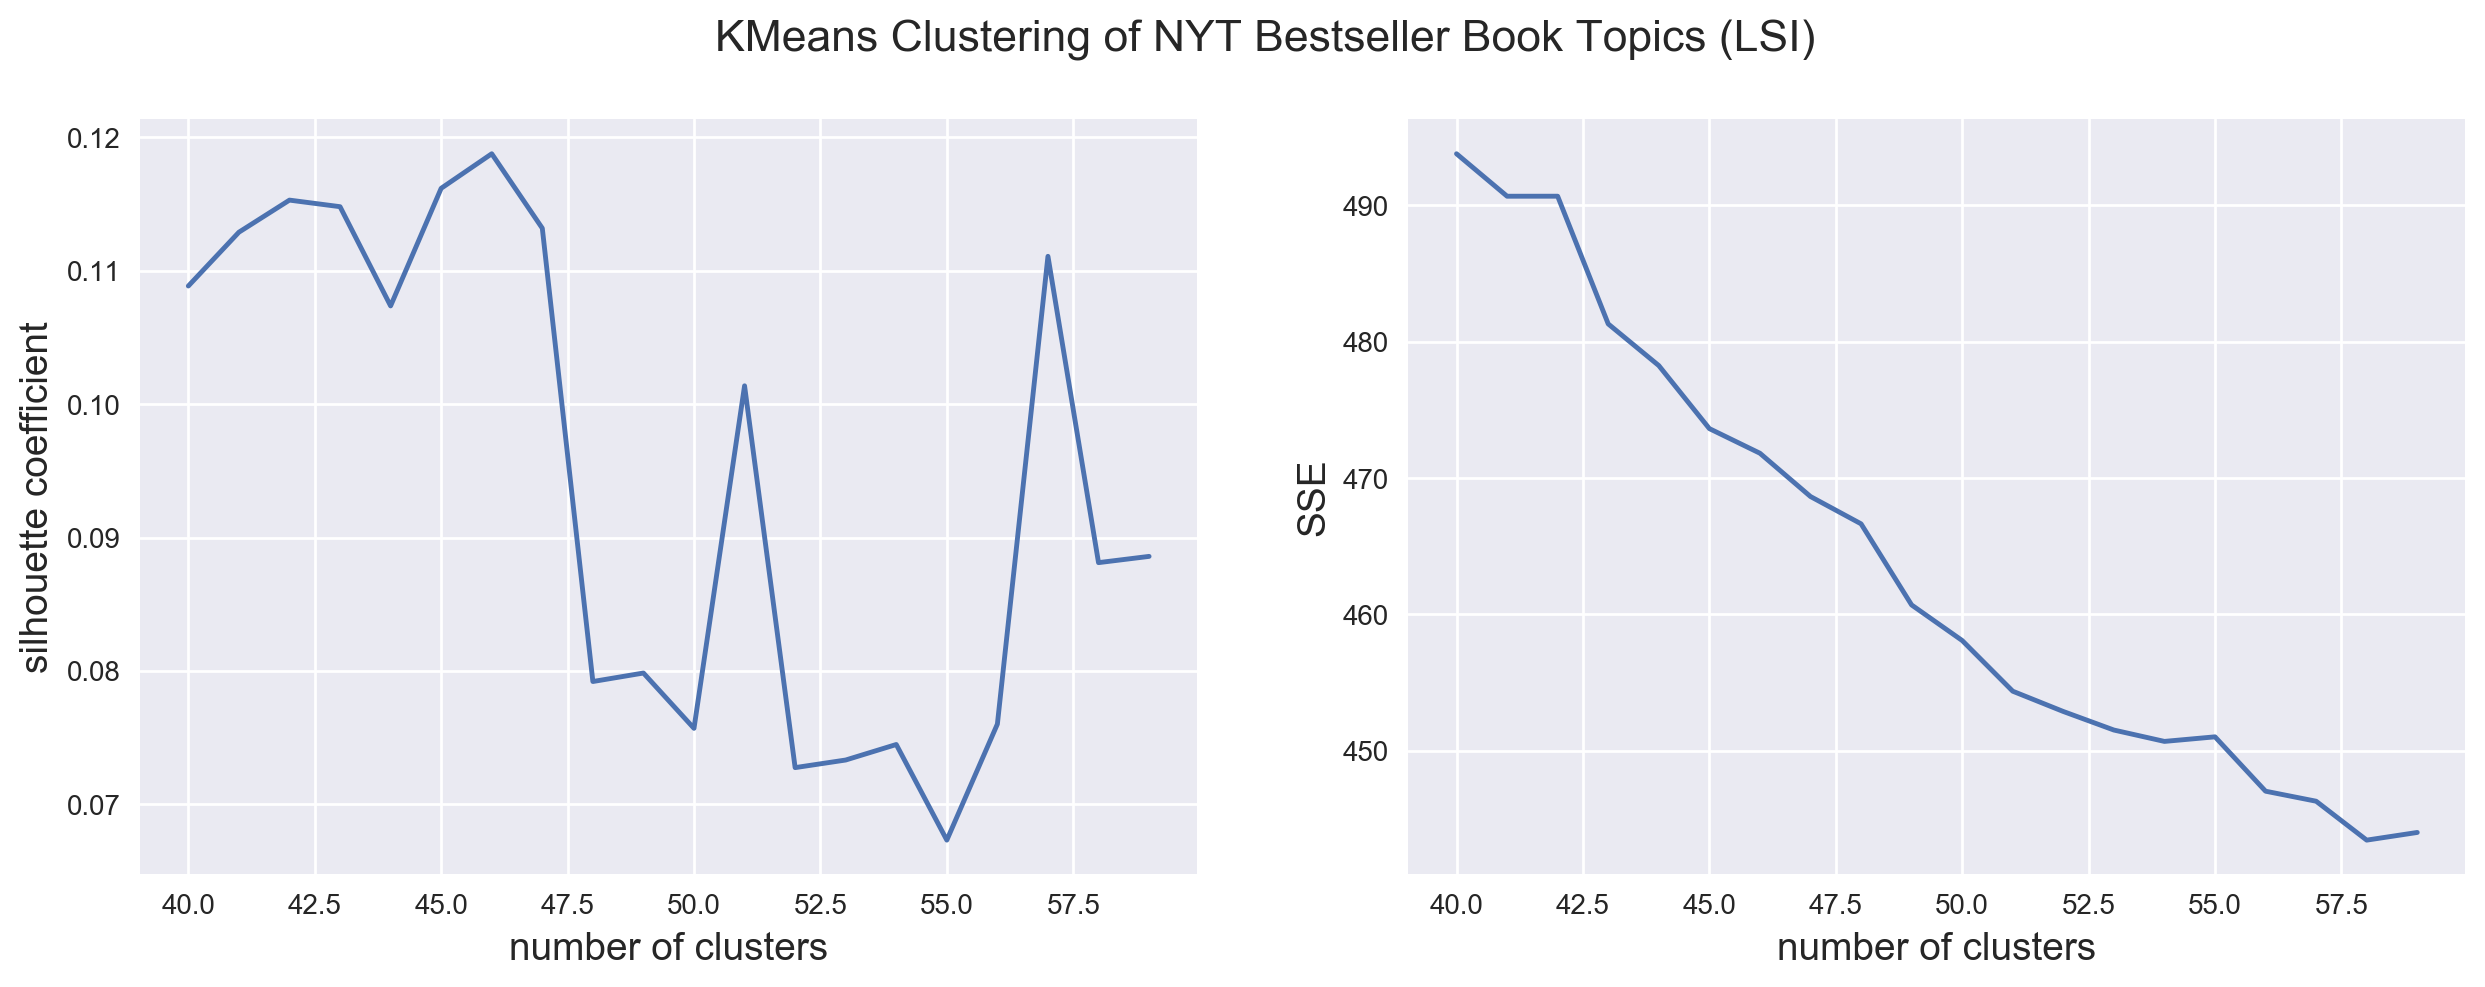

In [113]:
# plot silhouette coefficients and SSEs (elbow plot)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(40,60)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters', size=14)
ax1.set_ylabel('silhouette coefficient', size=14)

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters', size=14)
ax2.set_ylabel('SSE', size=14)

plt.suptitle('KMeans Clustering of NYT Bestseller Book Topics (LSI)', size=16);

## Other Viz

**long tail words**  
of 31,744 two-letter unigrams
- 13,539 (42.6%) only occur in 1 document 
- 22,218 (69.9%) occur is less than 5 documents (.04%)

of 310,829 two-letter bigrams  
- 266,358 (85.6%) only occur in 1 document

only 3 words occur in more than 10% of documents  
- {'life', 'new', 'world'}

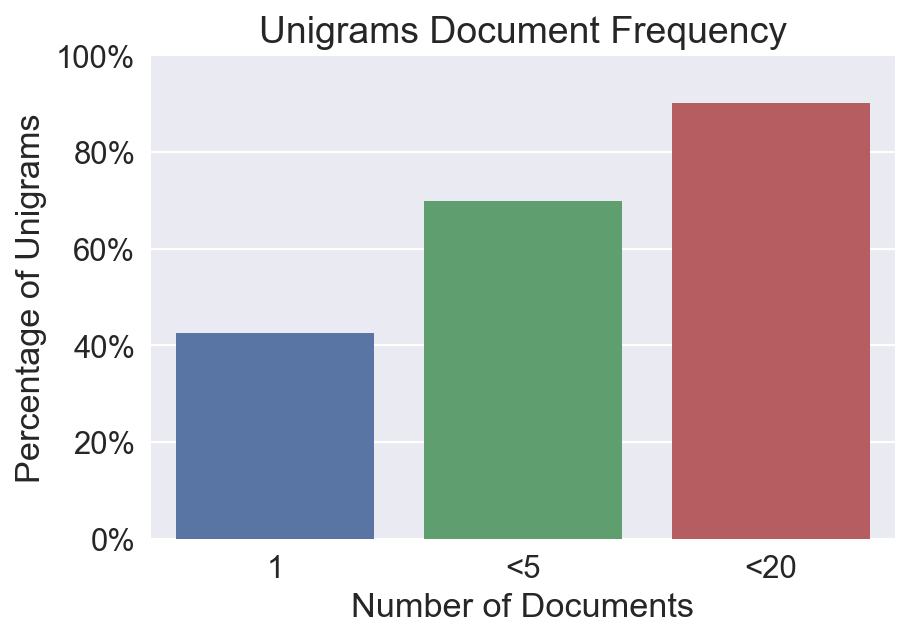

In [98]:
unigrams = [.426,.699,.901]
u_labels = ['1','<5','<20']
y_labels = ['0%','20%','40%','60%','80%','100%']

sns.set(font_scale=1.4)
plt.figure(figsize=(6,4), dpi=160)
sns.barplot(x=u_labels,y=unigrams)
plt.yticks(np.arange(0,1.2,.2),y_labels)
plt.xlabel('Number of Documents')
plt.ylabel('Percentage of Unigrams')
plt.title('Unigrams Document Frequency');

In [73]:
np.arange(0,1.1,.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])